In [11]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed market list
Hand cleaned to removed duplicates.  

In [12]:
cleansed=load_amihud_markets_price()

In [13]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

In [14]:
FF_daily=pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0)
FF_monthly=FF_daily.resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from IPython.kernel.zmq import kernelapp as app


# Run Fama MacBeth regressions 

Then correlation matrix 
* Market factor (using Kenneth French's Mkt-Rf' factor on webpage
* Market illiquidity (median Amihud through time series on futures data


In [15]:
factors=pd.DataFrame()
factors['Median Illiquidity']=amihud.median(axis=1).dropna()*1e10
factors['Mkt-Rf']=FF_monthly['Mkt-RF']
factor_names = factors.columns
factors['Intercept']=1
ind=factors.index

In [16]:
data=cleansed.resample(rule='m',how='last').pct_change().ix[ind]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


First pass (Time Series Regression)

* Estimate betas from the factors

In [17]:
param={}
for f in factors.columns:
    param[f]=pd.Series()
for m in data.columns:
    ind=data[m].dropna().index
    res=sm.OLS(data[m].ix[ind],factors.ix[ind]).fit()
    for f in factors.columns:
        param[f][m]=res.params[f]
beta_hat=pd.DataFrame(param)
beta_hat['Intercept']=1

Second pass (Cross sectional regression)

* Using $\hat{\beta}$ from previous regressions to estimate $\hat{\lambda}$

In [18]:
param={}
for f in factors.index:
    param[f]=pd.Series()
for t in factors.index:
    ind=data.T[t].dropna().index
    res=sm.OLS(data[ind].T[t].T,beta_hat.T[ind].T).fit()
    for f in factors.columns:
        param[t][f]=res.params[f]
lambda_hat=pd.DataFrame(param).T

In [19]:
lambda_hat.mean()*12

Median Illiquidity    1.399265
Mkt-Rf               -0.850009
Intercept             0.063798
dtype: float64

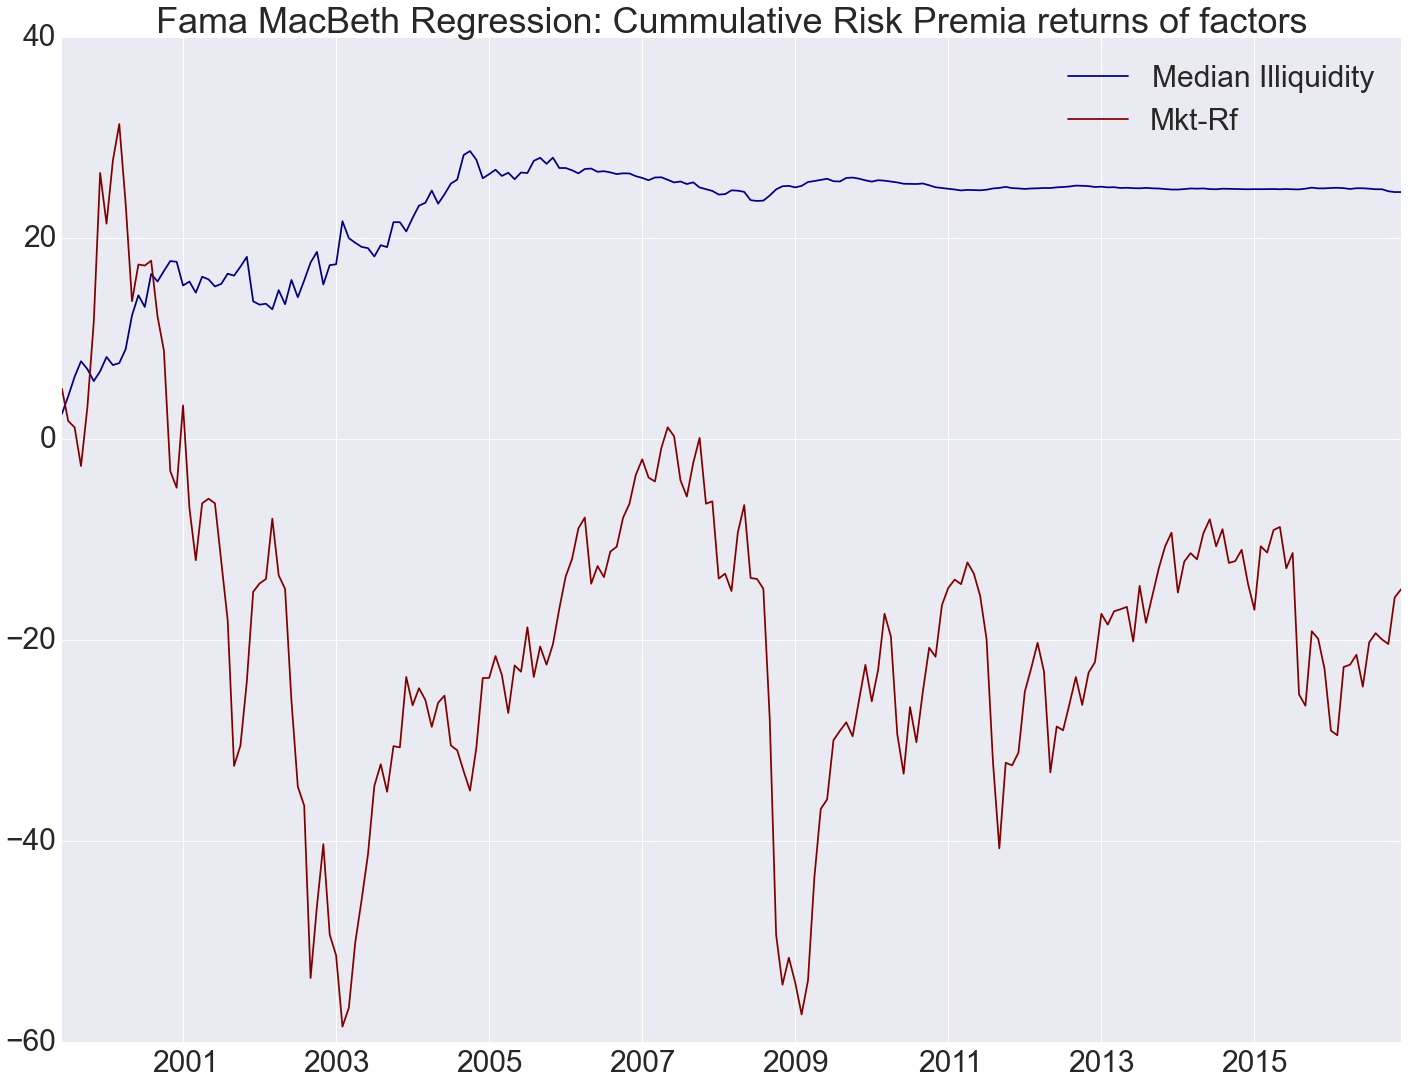

In [20]:
lambda_hat[factor_names].cumsum().plot(colormap='jet',
                                       title='Fama MacBeth Regression: Cummulative Risk Premia returns of factors')

* Need to add tstat
* This analysis is for priced literature